**A) Basic Configuration**

In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash #update repo

Updating fastai...
Done.


In [0]:
from fastai import *
from fastai.vision import *
#import fastai

In [0]:
#to create the actual folder/file with specific path on the cloud (to download files on)
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**B) Collecting and Preparing the Dataset**





In [0]:
#specify the folder/file names
folder ="memes"
file ="memes.txt"

In [0]:
#to create the folder with specific path on the cloud
path = Path(base_dir)
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)


In [0]:
#to download the images on the cloud (google drive)
download_images(path/folder/file, dest, max_pics=200)

In [0]:
folder ="nonmemes"
file ="nonmemes.txt"

In [0]:
path = Path(base_dir)
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [0]:
download_images(path/folder/file, dest, max_pics=200)

In [0]:
#identify the different classes 
classes = ['memes','nonmemes']

In [0]:
#remove corrupt images in which the links do not work anymore
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)


memes


nonmemes


**C) View Data**

In [0]:
np.random.seed(42) #reproducible 
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes #checking the classes/possible labels

['data', 'memes', 'nonmemes']

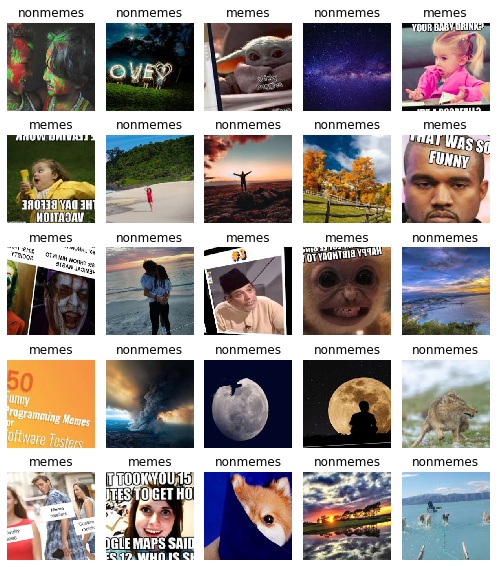

In [0]:
data.show_batch(rows=5, figsize=(7,8)) #show a sample of the data

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds) #data.c how many possible labels 

(['data', 'memes', 'nonmemes'], 3, 161, 40)

**D) Training the Model**

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.513895,0.533113,0.250000,00:03
1,1.110294,0.747021,0.200000,00:02
2,0.801721,0.505882,0.150000,00:02
3,0.629485,0.270249,0.100000,00:02


In [0]:
learn.save('stage-1') #save results

In [0]:
learn.unfreeze() #unfreeze to try again??

In [0]:
learn.lr_find() #find learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


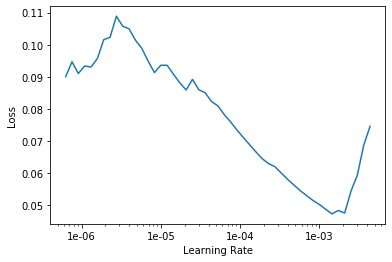

In [0]:
learn.recorder.plot() 

In [0]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.083441,0.201371,0.050000,00:02
1,0.055234,0.142688,0.050000,00:02


In [0]:
learn.save('stage-2')#save the results

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4)) #try different learning rate
#much better!!

epoch,train_loss,valid_loss,error_rate,time
0,0.026477,0.082009,0.050000,00:02
1,0.021360,0.064825,0.025000,00:02


In [0]:
learn.save('stage-3')

**E) Interpret Results**

In [0]:
learn.load('stage-3')#loading the most successful model

Learner(data=ImageDataBunch;

Train: LabelList (161 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
data,memes,memes,memes,memes
Path: /content/gdrive/My Drive/fastai-v3/data;

Valid: LabelList (40 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
memes,memes,memes,nonmemes,nonmemes
Path: /content/gdrive/My Drive/fastai-v3/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): Batc

In [0]:
interpretation = ClassificationInterpretation.from_learner(learn)

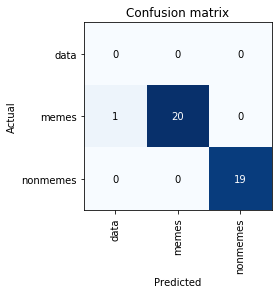

In [0]:
interpretation.plot_confusion_matrix()

**F) Cleaning Up the Data**

In [0]:
from fastai.widgets import *


In [0]:
losses,idxs= interpretation.top_losses()
top_loss_paths = data.valid_ds.x[idxs]
#look at the things the model was most confident about and was wrong, or wasn't confident about
# x refers to the file names
#y  refers to the label names

In [0]:
#clear noise from the training dataset too
losses,idxs= interpretation.top_losses()
top_loss_paths = data.train_ds.x[idxs]
#look at the things the model was most confident about and was wrong, or wasn't confident about
# x refers to the file names
#y  refers to the label names
fd = ImageDeleter(file_paths=top_loss_paths)
#colab does not support widgets :( 

In [0]:
# fd=ImageDeleter(file_paths=top_loss_paths)

In [0]:
#for inference we can use CPU (not training)

In [0]:
data.classes

**App in Production**

In [0]:
img=open_image(path/'dora.jpg')
#testing the model

In [0]:
img

In [0]:
classes=["memes","nonmemes"]
data2=ImageDataBunch.single_from_classes(path, classes,
        ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [0]:
learn=create_cnn(data2,models.resnet34)
learn.load('stage-3')

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

In [0]:
learn.export

<bound method Learner.export of Learner(data=ImageDataBunch;

Train: LabelList (161 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
data,memes,memes,memes,memes
Path: /content/gdrive/My Drive/fastai-v3/data;

Valid: LabelList (40 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
memes,memes,memes,nonmemes,nonmemes
Path: /content/gdrive/My Drive/fastai-v3/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

In [0]:
doc(learn.export)

In [0]:
learn.export('stage-3')